# 25) Coprocessor architectures

Last time:

- Collective operations
- Naive and MST algorithms

Today:

1. Coprocessor architectures  
2. Energy efficiency  
3. Programming models for GPUs
 

## 1. Coprocessor architectures  

A single node on the [Summit cupercomputer](https://en.wikipedia.org/wiki/Summit_(supercomputer)) (which held the number 1 position on the TOP500 list from November 2018 to June 2020.):

![](https://en.wikichip.org/w/images/0/06/summit_single-node.svg)

Some examples of supercomputers, most of which made the top of the [top-500](https://top500.org/) list:

* CUDA devices (NVIDIA)
  * Programmable via **CUDA**, OpenACC, OpenMP-5, OpenCL, HIP->CUDA, SYCL->CUDA
  * Example machine: [OLCF Summit](https://en.wikichip.org/wiki/supercomputers/summit) 
* ROCm devices (AMD)
  * Programmable via **HIP**, OpenMP-5, OpenCL, SYCL->HIP
  * Example machines: 
    - [OLCF Frontier](https://en.wikipedia.org/wiki/Frontier_(supercomputer)), the world's **first exascale supercomputer**. It was the fastest supercomputer in the world between 2022 and 2024 (superseded by El Capitan). [Spec sheet](https://www.olcf.ornl.gov/wp-content/uploads/2019/05/frontier_specsheet_v4.pdf).
    - [LLNL El Capitan](https://en.wikipedia.org/wiki/Fugaku_(supercomputer)) (AMD 4th Gen EPYC 24C "Genoa" 24-core 1.8 GHz CPUs and AMD Instinct MI300A GPUs).
* Intel X GPUs
  * Programmable via **SYCL**, OpenMP-5, OpenCL?
  * Example machine: [ALCF Aurora/A21](https://www.anl.gov/aurora)
* Non-coprocessor supercomputers:
  * [Fugaku (Post-K)](https://en.wikipedia.org/wiki/Fugaku_(supercomputer)) It became the fastest supercomputer in the world in the June 2020 TOP500 list as well as becoming the first ARM architecture-based computer to achieve this. Fugaku was superseded as the fastest supercomputer in the world by Frontier in May 2022.
  * [TACC Frontera](https://www.tacc.utexas.edu/systems/frontera)

### Fundamental capabilities

In [3]:
using CSV
using DataFrames

data = """
package,cores,lanes/core,clock (MHz),peak (GF),bandwidth (GB/s),TDP (W),MSRP
Xeon 8280,28,8,2700,2400,141,205,10000
NVIDIA V100,80,64,1455,7800,900,300,10664
AMD MI60,64,64,1800,7362,1024,300,
AMD Rome,64,4,2000,2048,205,200,6450
"""

# Read the data into a DataFrame
df = CSV.File(IOBuffer(data)) |> DataFrame

# Set the index column to "package"
df.package .= String.(df.package);  # Ensure package names are strings


In [4]:
df

Row,package,cores,lanes/core,clock (MHz),peak (GF),bandwidth (GB/s),TDP (W),MSRP
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64?
1,Xeon 8280,28,8,2700,2400,141,205,10000
2,NVIDIA V100,80,64,1455,7800,900,300,10664
3,AMD MI60,64,64,1800,7362,1024,300,missing
4,AMD Rome,64,4,2000,2048,205,200,6450


## 2. Energy efficiency

### [Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law) for energy efficiency

In [20]:
# Compute efficiency (GF/W) and add it as a new column
df[!, :efficiency_GF_per_W] = df."peak (GF)" ./ df."TDP (W)"
println(df[:, [:package, :efficiency_GF_per_W]])

4×2 DataFrame
 Row │ package      efficiency_GF_per_W 
     │ String       Float64             
─────┼──────────────────────────────────
   1 │ Xeon 8280                11.7073
   2 │ NVIDIA V100              26.0
   3 │ AMD MI60                 24.54
   4 │ AMD Rome                 10.24


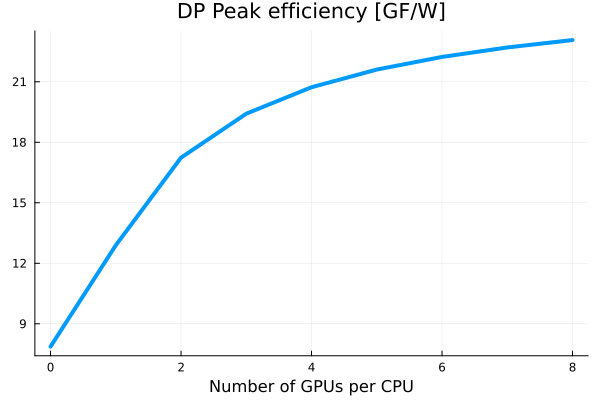

In [26]:
using Plots
default(linewidth=4, legendfontsize=12)

ngpu = 0:8
overhead = 100  # Power supply, DRAM, disk, etc.

# Compute peak performance
peak = (ngpu .== 0) .* df[df.package .== "Xeon 8280", :"peak (GF)"][1] .+ ngpu .* df[df.package .== "NVIDIA V100", :"peak (GF)"][1]

# Compute total power consumption
tdp = overhead .+ df[df.package .== "Xeon 8280", :"TDP (W)"][1] .+ ngpu .* df[df.package .== "NVIDIA V100", :"TDP (W)"][1]

# Plot
plot(ngpu, peak ./ tdp, xlabel="Number of GPUs per CPU", title="DP Peak efficiency [GF/W]", label = "")

#### Compare to [Green 500 list](https://www.top500.org/lists/green500/2024/11/)

As of [November 2024](https://top500.org/lists/green500/2024/11/):
* [#1 system: JEDI (JUPITER Exascale Development Instrument at EuroHPC/FZJ in Germany)](https://www.top500.org/system/180269/) is **72.733 GF/W** (BullSequana XH3000 machine with an NVIDIA Grace Hopper Superchip 72C)
* [#2 system: ROMEO HPC Center - Champagne- Ardenne in France](https://www.top500.org/system/180311/) is **70.912 GF/W** (ROMEO-2025 - BullSequana XH3000, Grace Hopper Superchip 72C 3GHz, NVIDIA GH200 Superchip)
* [#3 system: Adastra 2 - Grand Equipement National de Calcul Intensif (France)](https://www.top500.org/system/180319/) is **69.098 GF/W** (HPE Cray EX255a, AMD 4th Gen EPYC 24C 1.8GHz, AMD Instinct MI300A)

### Amdahl's law for cost efficiency

In [29]:
# Compute cost efficiency (GF per dollar) and add it as a new column
df[!, :cost_GF_per_dollar] = df."peak (GF)" ./ df.MSRP

println(df[:, [:package, :cost_GF_per_dollar]])

4×2 DataFrame
 Row │ package      cost_GF_per_dollar 
     │ String       Float64?           
─────┼─────────────────────────────────
   1 │ Xeon 8280              0.24
   2 │ NVIDIA V100            0.731433
   3 │ AMD MI60         missing        
   4 │ AMD Rome               0.317519


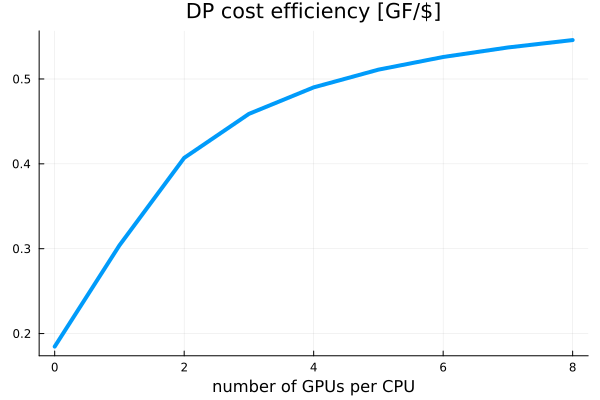

In [43]:
overhead = 3000 .+ 2000 * ngpu  # power supply, memory, cooling, maintenance

cost = overhead .+ df[df.package .== "Xeon 8280", :"MSRP"][1] .+ ngpu * df[df.package .== "NVIDIA V100", :"MSRP"][1]

plot(ngpu, peak ./ cost, xlabel="number of GPUs per CPU", title="DP cost efficiency [GF/\$]", label = "")


### What fraction of datacenter cost goes to the power bill?

* OLCF Summit is reportedly a \$200M machine.
* What if we just buy the GPUs at retail?
  * 256 racks
  * 18 nodes per rack
  * 6 GPUs per node
  * V100 MSRP of about \$10k

In [44]:
256 * 18 * 6 * 10e3 / 1e6 # millions

276.48

~\$276 M

* Rule of thumb: $ \lesssim \$1M $ per MW-year
* We know Summit is a 13 MW facility
* Check [industrial electricity rates](https://www.electricitylocal.com/states/tennessee/knoxville/) in Tennessee (piture below from 2019)

![](../img/knoxville-electricity.png)

In [45]:
.0638 * 24 * 365

558.8879999999999

~ 558 MW-year

## 3. Programming models for GPUs

* Directives
  * [OpenMP-6](https://www.openmp.org/resources/refguides/)
  * [OpenACC](https://www.openacc.org/) (As in OpenMP, the programmer can annotate native C, C++ and Fortran source code to identify the areas that should be accelerated using compiler directives and additional functions.)

Example:

A C snippet annotated with OpenACC directives:

```c
#pragma acc data copy(A) create(Anew)
while ( error > tol  &&  iter  <  iter_max )  {
  error = 0.0;
#pragma acc kernels {
#pragma acc loop independent collapse(2)
  for (  int  j = 1; j < n-1;  j++ )  {
    for (  int  i = 1; i < m-1; i++ )  {
       Anew [j] [i] = 0.25 * ( A [j] [i+1] + A [j] [i-1] +
                                      A [j-1] [i] + A [j+1] [i]);
       error = max ( error, fabs (Anew [j] [i] - A [j] [i]));
      }
    }
  } 
}
```

A more direct approach to GPU programming:

- GPUs have been designed to execute many similar commands, or threads, in parallel, achieving higher throughput. Latency is the time between starting an operation and receiving its result, such as 2 ns, while throughput is the rate of completed operations, for example, operations per second.

* Thread "kernel" and control:
  * [CUDA](https://devblogs.nvidia.com/even-easier-introduction-cuda/)
  * [HIP](https://rocm.docs.amd.com/projects/HIP/en/latest/understand/programming_model.html) ([video](https://vimeo.com/channels/olcftraining/359154970))
* C++ templated/abstractions:
  * [SYCL](https://www.khronos.org/sycl/) (abstractions to enable heterogeneous device programming)
  * [Kokkos](https://github.com/kokkos/kokkos)
  * [Raja](https://github.com/LLNL/RAJA)